## Import packages and set seed

- It is highly probable that the folder "auxiliary_scripts" will change its name in the future.
- If this happens then it would be converted into a package called "wavesuite_auxiliary_scripts" and it would have to be installed and imported

In [1]:
#It is highly probable that this folder will chnage its name in th future
import sys

sys.path.insert(0, '../auxiliary_scripts/')

In [2]:
import time  
import numpy as np

from torch_geometric.loader import DataLoader

In [3]:
#import AE_Models
from train_AE_functions import set_seed, train_AE, model_MSE_error

from graph_functions import create_graph_data_list_vtu_file
from plot_results_vtu import plot_model_2d_vtu, compare_four_plots_models_2d_vtu 

from rank_models import plot_losses , rank_losses

In [4]:
set_seed(42)

True

## Create the list of Data objects where each element is a graph

In [5]:
location = '../../Datasets/air_pollution_data/2d_canyon_' 
start_index = 0
end_index = 401

vtu_file_locations_air = [ location + str(i) + '.vtu' for i in range(start_index, end_index)]
features_list_air = ['TracerBackground']  

In [6]:
graph_data_list_air, n_points = create_graph_data_list_vtu_file(vtu_file_locations_air, features_list_air)

In [7]:
graph_data_list_air[0]

Data(x=[852, 1], edge_index=[2, 2419])

## Shuffle graph_data_list before splitting

In [8]:
#Compute the number of graphs
n_graphs = len(graph_data_list_air)

#Compute one random permutation
permutation0 = np.random.permutation(n_graphs)

In [9]:
shuffle = True

if shuffle:
    #Reorganize graph_data_list taking into account the previous random permutation
    input_graph_data_list = [graph_data_list_air[entry] for entry in permutation0]
else: 
    input_graph_data_list = graph_data_list_air

## Create DataLoaders

In [10]:
n_graphs = len(input_graph_data_list)

graph_data_list_train = input_graph_data_list[:int(n_graphs * 0.8)]
graph_data_list_validation = input_graph_data_list[int(n_graphs * 0.8):int(n_graphs * 0.9)]
graph_data_list_test = input_graph_data_list[int(n_graphs * 0.9):]

print(len(graph_data_list_train))
print(len(graph_data_list_validation))
print(len(graph_data_list_test))

320
40
41


In [11]:
NUM_GRAPHS_PER_BATCH = 32

train_loader = DataLoader(graph_data_list_train, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
validation_loader = DataLoader(graph_data_list_validation, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(graph_data_list_test, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

## Let's train some models

In [12]:
#This dictionary stores the losses results of the models
results_models = {}

In [13]:
#These are the models specifications
num_features = 1  #This is always 1
latent_space_dim = 32
num_epochs = 50  #CHANGE TO 50 

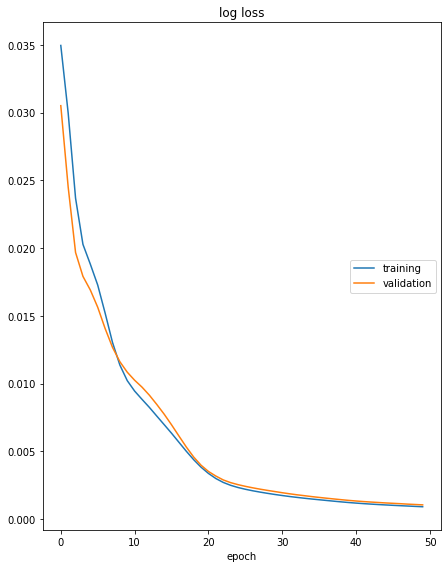

log loss
	training         	 (min:    0.001, max:    0.035, cur:    0.001)
	validation       	 (min:    0.001, max:    0.031, cur:    0.001)

 Number of parameters:  114164
Time taken:  12.774947881698608


In [14]:
start = time.time()

model_name = 'classic_AE'
embedding_sequence = None # There is no embedding sequence for classic AE, just input None

model1, results_models[model_name] = train_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type=model_name, 
                                                num_epochs=num_epochs)

end = time.time()

print('Time taken: ',end-start) 

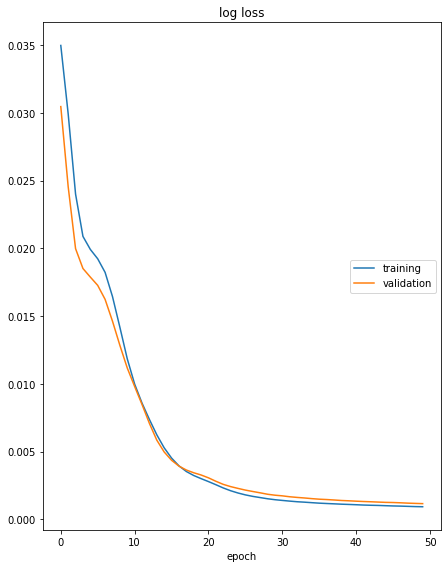

log loss
	training         	 (min:    0.001, max:    0.035, cur:    0.001)
	validation       	 (min:    0.001, max:    0.030, cur:    0.001)

 Number of parameters:  168886
Time taken:  14.33385705947876


In [15]:
start = time.time()

model_name = 'GCN_AE'
embedding_sequence = [8, 16, 2]  #The third entry determines the number of parameters

model2, results_models[model_name] = train_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type=model_name, 
                                                num_epochs=num_epochs)

end = time.time()

print('Time taken: ',end-start) 

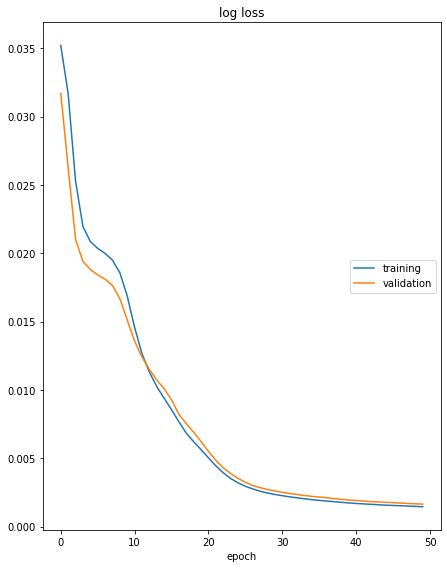

log loss
	training         	 (min:    0.001, max:    0.035, cur:    0.001)
	validation       	 (min:    0.002, max:    0.032, cur:    0.002)

 Number of parameters:  224459
Time taken:  16.494232177734375


In [16]:
start = time.time()

model_name = 'GCN_AE_GCN'
embedding_sequence = [8, 16, 2, 2, 16, 8]  #The third and fourth entries determine the number of parameters

model3, results_models[model_name] = train_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type=model_name, 
                                                num_epochs=num_epochs)

end = time.time()

print('Time taken: ',end-start) 

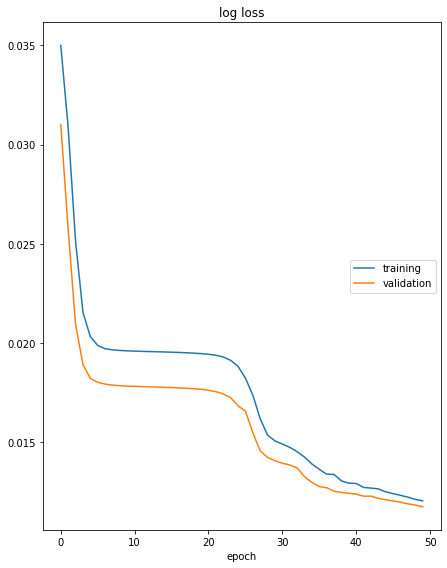

log loss
	training         	 (min:    0.012, max:    0.035, cur:    0.012)
	validation       	 (min:    0.012, max:    0.031, cur:    0.012)

 Number of parameters:  136564
Time taken:  20.42753577232361


In [17]:
start = time.time()

model_name = 'GCN_pooling_AE'
embedding_sequence = [8, 16, 32, 64, 128, 256]   #The last entry, sixth in this case, determines the number of parameters

model4, results_models[model_name] = train_AE(train_loader, validation_loader, 
                                                n_points, num_features, embedding_sequence=embedding_sequence , 
                                                latent_space_dim=latent_space_dim, ae_model_type=model_name, 
                                                num_epochs=num_epochs)

end = time.time()

print('Time taken: ',end-start) 

## MSE results

In [18]:
models_names = list( results_models.keys() )

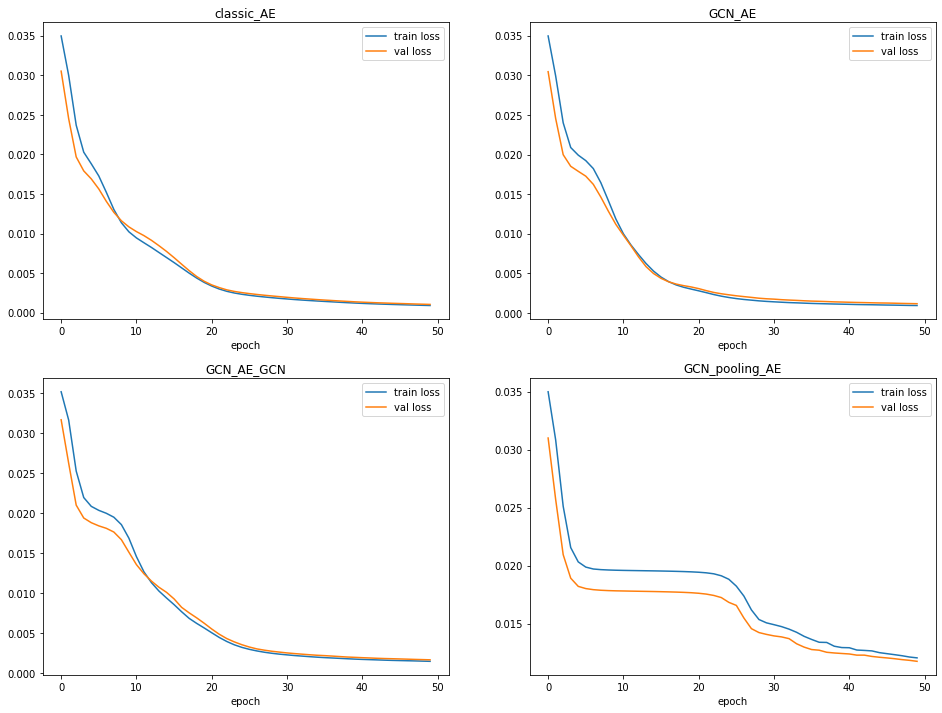

In [19]:
filename = 'air_pollution_models_losses.png'
plot_losses(results_models, models_names, filename=filename, figsize=(16,12))

In [20]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/4) )

,variants_name,final_validation_loss
0,GCN_AE,0.008479
1,classic_AE,0.009741
2,GCN_AE_GCN,0.012411
3,GCN_pooling_AE,0.017806


In [21]:
rank_losses(results_models, models_names, selected_epoch = int(num_epochs/2) )

,variants_name,final_validation_loss
0,GCN_AE,0.002287
1,classic_AE,0.002547
2,GCN_AE_GCN,0.003533
3,GCN_pooling_AE,0.016838


In [22]:
first_column_model_name = 'AE Models Sigmoid output'
filename = 'air_pollution_models_losses.csv'

df_losses = rank_losses(results_models, models_names, selected_epoch = num_epochs,
                        first_column_model_name = first_column_model_name, 
                        filename = filename )

df_losses

CSV was saved


,Model name,variants_name,final_validation_loss
0,AE Models Sigmoid output,classic_AE,0.001055
1,AE Models Sigmoid output,GCN_AE,0.001163
2,AE Models Sigmoid output,GCN_AE_GCN,0.001640
3,AE Models Sigmoid output,GCN_pooling_AE,0.011752


In [23]:
print( 'model1 error: ', model_MSE_error(model1, test_loader) )
print( 'model2 error: ', model_MSE_error(model2, test_loader) )
print( 'model3 error: ', model_MSE_error(model3, test_loader) )
print( 'model4 error: ', model_MSE_error(model4, test_loader) )

model1 error:  0.0010092756
model2 error:  0.0011996593
model3 error:  0.0016159597
model4 error:  0.01035868


# Plot the results

In [24]:
filename_to_copy_structure = '../../Datasets/air_pollution_data/2d_canyon_1.vtu'

Indexes plotted [1, 10, 20, 39]


C:\Users\angel\Anaconda3\envs\second-try-alienware\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


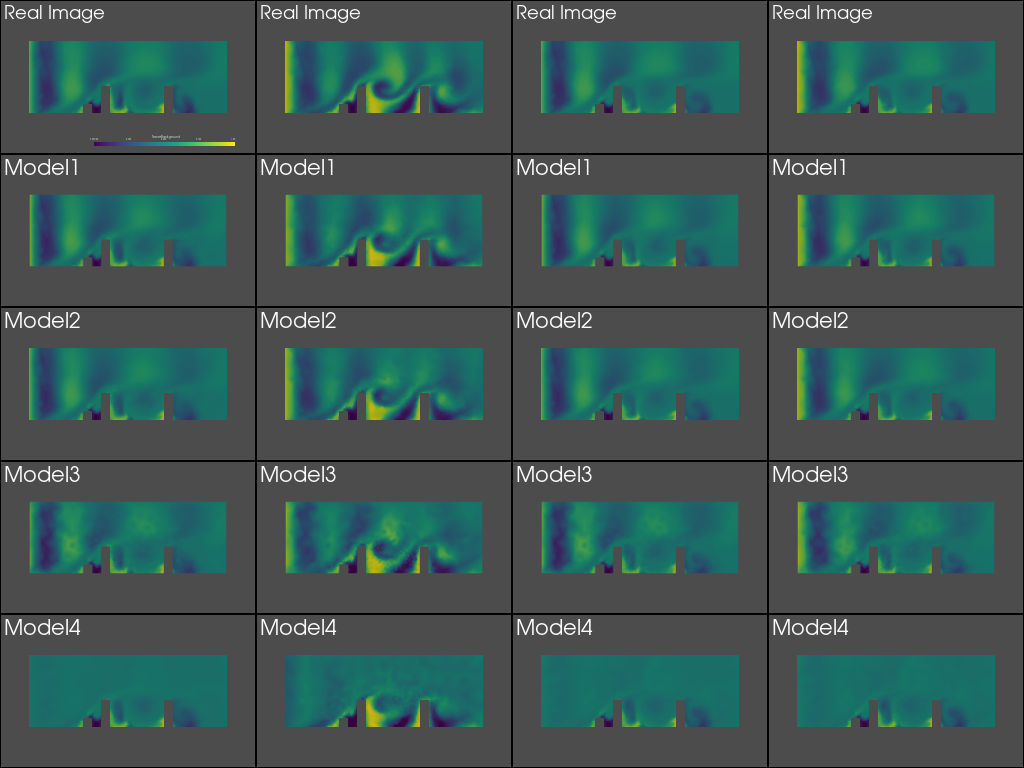

In [25]:
#file extension can be '.svg', '.eps', '.ps', '.pdf', '.tex'
compare_four_plots_models_2d_vtu(model1, model2, model3, model4, 
                            graph_data_list_test, 4 , filename_to_copy_structure, 
                            random=False, index_sequence=[ 1, 10, 20, 39], 
                                 set_pred_labels_as = ["Model1", "Model2", "Model3", "Model4"],
                            save_fig=True, filename='air_pollution_models_decompressed.eps'  ) 

Hey, I decided to play with the embedding_sequence of model2 and I found out that the more number of layers the better results I get, which of course makes a lot of sense

However, the third entry of the embedding sequence is conflictive: Off course I want it to be high but making it high increases the number of parameters by a lot

If I leave the layer equal to 1 the results go bad, and it makes a lot of sense because 1 layer is only input_data but corrupted, right? Whereas if I use at least 2 layers then I get input layer but enhanced. So, so far I have the hypothesis that 
number_of_channels_in_last_layer = 2 is the way to go 

Indexes plotted [38 28 14]


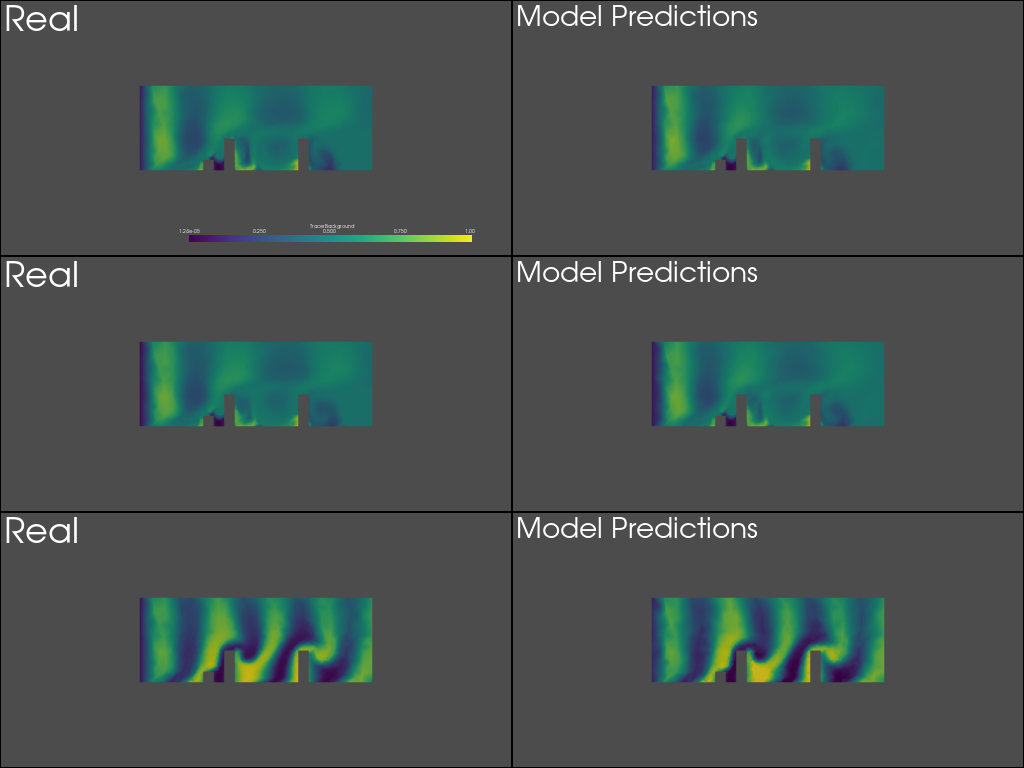

In [26]:
plot_model_2d_vtu(model1, graph_data_list_test, 3 , filename_to_copy_structure , random=True)

Indexes plotted [1, 20, 35]


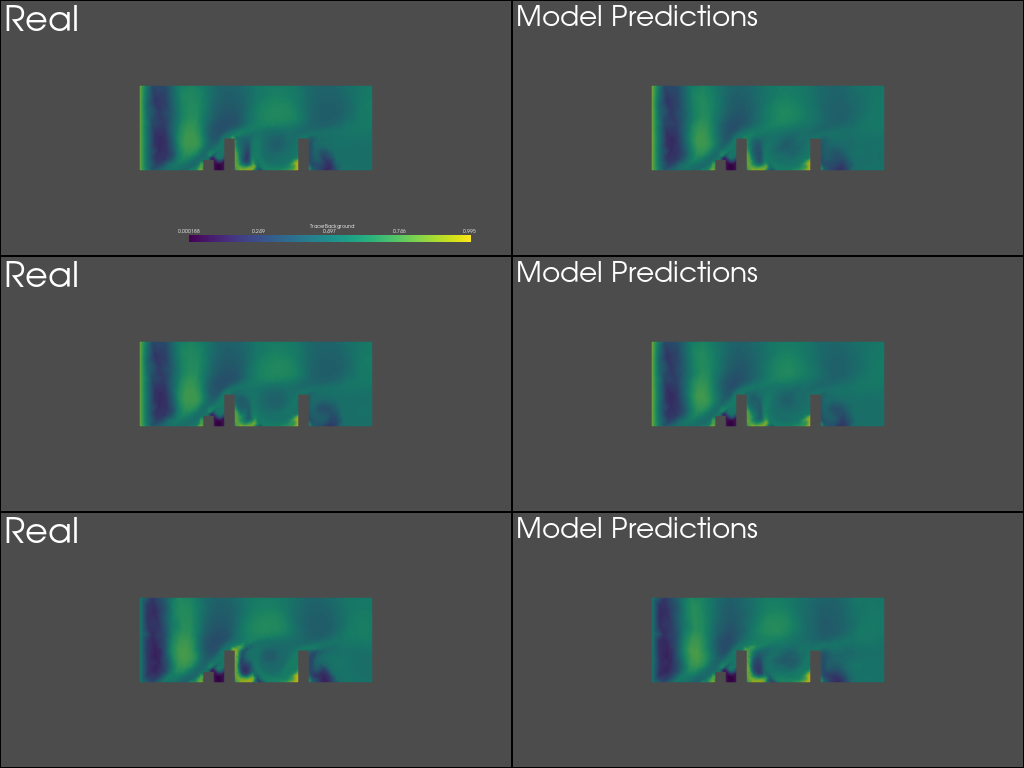

In [27]:
plot_model_2d_vtu(model2, graph_data_list_test, 2 , filename_to_copy_structure , random=False, index_sequence=[1,20, 35] )